### Libraries

In [1]:
import pandas as pd
import skvideo.io  
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.decomposition import PCA
from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet import ResNet50
from PIL import Image as pil_image
from numpy import load
from numpy import asarray

from keras.models import load_model 
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
model_vgg16_conv = VGG16(weights='imagenet', include_top=True)
print(model_vgg16_conv.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Helper Functions

In [2]:
def extract_image(frame,left,top,width,height):
    video_width = videodata.shape[1]
    video_length = videodata.shape[2]
    cutshot = videodata[int(frame),int(top*video_width/240):int((top+height)*video_width/240),int(left*video_length/320):int((left+width)*video_length/320),:]
    w,h = cutshot.shape[0],cutshot.shape[1]
    if w>h:
        return np.pad(cutshot,((0,0),(0,w-h),(0,0)))
    else: 
        return np.pad(cutshot,((0,h-w),(0,0),(0,0)))
    

In [3]:
def view_image(frame,left,top,width,height):
    video_width = videodata.shape[1]
    video_length = videodata.shape[2]
    cutshot = videodata[int(frame),int(top*video_width/240):int((top+height)*video_width/240),int(left*video_length/320):int((left+width)*video_length/320),:]
    
    w,h = cutshot.shape[0],cutshot.shape[1]
    if w>h:
        plt.imshow(np.pad(cutshot,((0,0),(0,w-h),(0,0))))
    else: 
        plt.imshow(np.pad(cutshot,((0,h-w),(0,0),(0,0))))
    plt.show()

In [4]:
### Generate Bag of Words Representation of Features and normalize them
def bow(feature_vectors):
    aggregate = feature_vectors.sum(axis = 0 )
    return (aggregate - aggregate.mean())/(aggregate.std() + 1e-30)

def Sift(sections):
    sift = cv2.SIFT_create()
    sift_descriptors = []
    for i in sections:
        i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        keypoints_1, descriptors_1 = sift.detectAndCompute(i,None)
        sift_descriptors.append(descriptors_1)
    return sift_descriptors
def Orb(sections):
    orb = cv2.ORB_create()
    orb_descriptors = []
    for i in sections:
        i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        keypoints_1, descriptors_1 = orb.detectAndCompute(i,None)
        orb_descriptors.append(descriptors_1)
    return orb_descriptors

In [5]:
def view_3(x,n=1):
    imgs = x.sample(n,replace=True)
    print(x.name)
    imgs.apply(lambda img: view_image(img['frame'],img['left'],img['top'],img['width'],img['height']),axis=1)

In [6]:
# Generalize the data and extract the embeddings
def extract_embeddings(model,face_pixels):
    face_pixels = face_pixels.astype('float32')  #convert the entire data to float32(base)
    mean = face_pixels.mean()                    #evaluate the mean of the data
    std  = face_pixels.std()                     #evaluate the standard deviation of the data
    face_pixels = (face_pixels - mean)/std       
    samples = np.expand_dims(face_pixels,axis=0)    #expand the dimension of data 
    yhat = model.predict(samples)
    return yhat[0]

In [7]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    print(counts)
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [8]:
def DBSCAN_clustering(embedding_tracker,eps = 7.6,min_samples = 2):
    clustering = DBSCAN(eps = eps , min_samples = min_samples).fit(embedding_tracker)
    clustering_labels = clustering.labels_ 
    print(np.unique(clustering_labels))
    plt.hist(clustering_labels)
    return clustering_labels

# Load Video Data and Tracker Data

In [10]:
videodata = skvideo.io.vread("Office.mp4")  
videodata.shape
##### Tracker Data

(4682, 480, 854, 3)

In [12]:
df = pd.read_csv("Office.csv",index_col=0)

In [13]:
df = df[df['tracker'].isin(np.where(df.groupby("tracker")['frame'].count()>20)[0])].reset_index(drop=True)

In [14]:
videodata.shape

(4682, 480, 854, 3)

### Load Sections and Resize The Video

In [15]:
sections = df.apply(lambda x: extract_image(x['frame'],x['left'],x['top'],x['width'],x['height']),axis=1)
sections = sections.apply(lambda x:  cv2.resize(x, dsize=(160, 160), interpolation=cv2.INTER_CUBIC))
sections = sections.apply(lambda x:  x.reshape(1,160,160,3))
sections = np.concatenate(sections.values)
selected_df = df.iloc[np.where(sections.sum(axis=1).sum(axis=1).sum(axis=1)!=0)].reset_index(drop=True).copy()
sections = sections[np.where(sections.sum(axis=1).sum(axis=1).sum(axis=1)!=0)]
print("There are ",sections.shape[0], " images with ",df['tracker'].nunique()," trackers")

There are  3513  images with  30  trackers


## Method 1: Facenet Feature Vector Clustering

### Generate Embeddings

In [16]:
# Load the compressed dataset and facenet keras model
model = load_model('facenet_keras.h5',compile=False)

# Get the face embeddings
embeddings = np.zeros((sections.shape[0],128))
for i in range(sections.shape[0]):
    embeddings[i] = extract_embeddings(model,sections[i])
    if(i%100==0):
        print(i)
# compress the 128 embeddings of each face 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


In [20]:
embedding_df = pd.DataFrame(embeddings)
embedding_df['tracker'] = selected_df['tracker']
embedding_tracker = embedding_df.groupby("tracker").apply(bow).iloc[:,:128]

In [21]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,tracker
0,1.767760,1.280080,1.210633,-0.498345,-1.120211,0.569538,0.565885,-1.313045,-0.220564,0.427370,...,0.586270,0.837989,-0.418977,-0.268618,-0.186699,0.082808,0.170981,0.050114,0.854225,0
1,1.989346,1.365874,0.805019,-1.100654,-1.461856,0.231026,-0.011178,-1.370002,-0.159150,-0.608007,...,0.845383,0.978274,0.135943,0.024190,-0.552487,0.229888,-0.288204,0.165024,1.159205,0
2,1.845357,1.311052,1.257082,-0.697749,-1.083501,0.494362,0.312336,-1.462817,-0.348749,0.283053,...,0.638778,0.757002,-0.372176,-0.069221,-0.285044,0.270670,0.136757,0.184603,0.924755,0
3,1.015208,0.930035,0.936860,-0.779148,-0.057554,1.397411,-0.267950,-0.615980,0.570042,0.143822,...,0.225719,-0.264257,-1.066061,1.211922,-0.487155,-0.197278,0.304888,-0.187087,0.879495,0
4,1.075471,1.066543,0.969578,-0.372036,-0.193376,1.351987,-0.076069,-0.686914,0.573139,0.364476,...,0.377647,-0.191873,-0.755011,0.609578,0.155265,-0.373272,0.696953,-0.323955,1.138860,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,0.562652,0.012988,0.723560,-0.890014,0.369325,1.483137,-0.416082,-0.131505,0.388531,0.554843,...,0.769961,-0.692124,-0.378619,0.931593,0.884217,-0.436247,0.638795,0.313667,0.372514,33
3509,0.368573,-0.089140,0.533586,-0.805890,0.411573,1.389764,-0.675402,-0.024058,0.398010,0.421320,...,0.543339,-0.606066,-0.540540,1.203150,0.856796,-0.141000,0.116272,0.604886,0.225447,33
3510,0.491146,0.003530,0.542837,-0.743986,0.437889,1.529645,-0.446661,-0.075628,0.288648,0.596991,...,0.720192,-0.802139,-0.491029,1.069862,0.762348,-0.279694,0.285596,0.567721,0.322440,33
3511,0.436389,0.052041,0.591176,-0.756725,0.346913,1.610472,-0.429931,-0.274635,0.132087,0.496032,...,0.708141,-0.897654,-0.499061,1.320194,0.891028,-0.198998,0.218609,0.652221,0.345245,33


### Clustering using DBSCAN Naive

[-1  0  1  2  3  4  5  6  7  8]


(array([  15., 1732.,  837.,  490.,  129.,  158.,   67.,    9.,   56.,
          20.]),
 array([-1. , -0.1,  0.8,  1.7,  2.6,  3.5,  4.4,  5.3,  6.2,  7.1,  8. ]),
 <BarContainer object of 10 artists>)

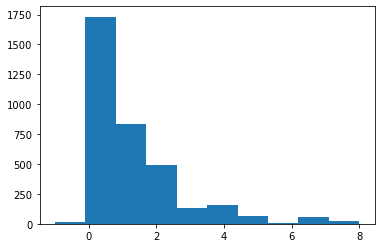

In [25]:
clustering = DBSCAN(eps = 5 , min_samples=5).fit(embeddings)
clustering_labels = clustering.labels_ 
print(np.unique(clustering_labels))
plt.hist(clustering_labels)

-1


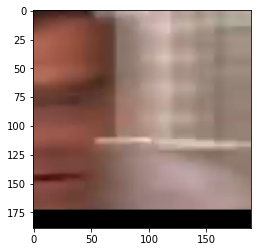

0


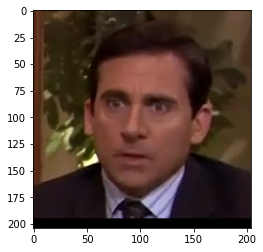

1


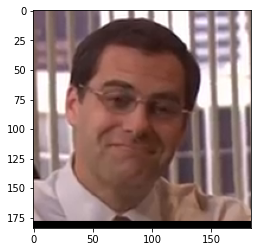

2


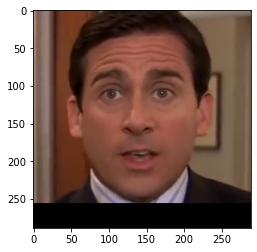

3


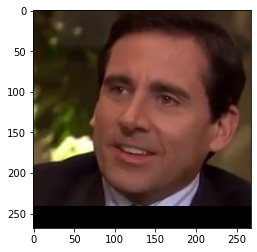

4


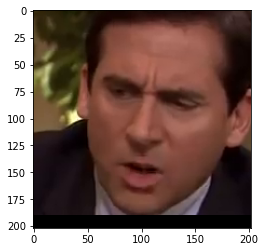

5


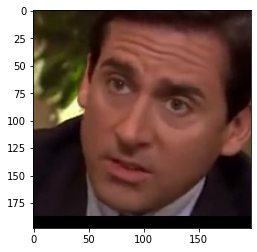

6


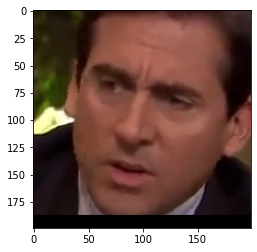

7


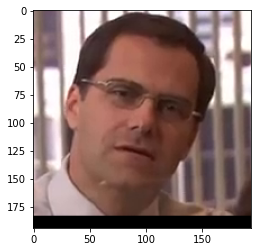

8


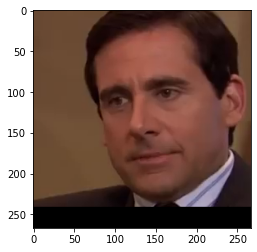

""


In [26]:
selected_df['cluster_naive'] = clustering_labels
selected_df.groupby('cluster_naive').apply(lambda x: view_3(x))

### Clustering using DBSCAN on Bag Of Words

[-1  0  1]


(array([17.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  6.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

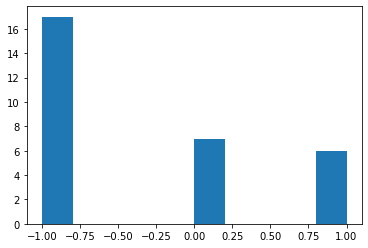

In [39]:
clustering = DBSCAN(eps =3, min_samples=3).fit(embedding_tracker)
clustering_labels = clustering.labels_ 
print(np.unique(clustering_labels))
plt.hist(clustering_labels)

-1


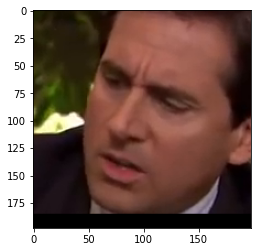

0


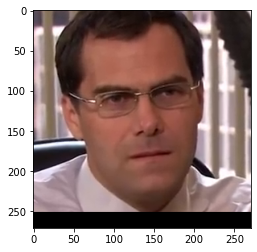

1


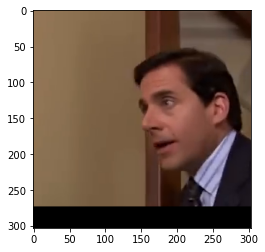

""


In [40]:
cluster_map = dict(zip(embedding_tracker.index,clustering_labels))
selected_df['cluster'] = selected_df['tracker'].apply(lambda x:cluster_map[x] if x in cluster_map.keys() else -1)
selected_df.groupby('cluster').apply(lambda x: view_3(x))

### Clustering using Dendograms (Heirarchical Clustering)

[ 2.  3.  4.  2.  2.  5.  2.  3.  2.  6.  2.  2.  4.  4.  3.  2.  3.  4.
  2.  3.  7.  7.  2. 11.  9.  4. 15. 19. 30.]


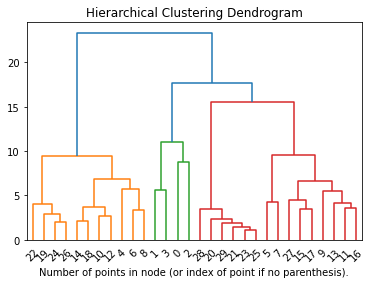

In [43]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
np.unique(model.fit(embedding_tracker).labels_)
model = model.fit(embedding_tracker)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
idxs = model.children_[-1]
n_samples = len(model.labels_)

In [42]:
model.children_

array([[23, 25],
       [21, 30],
       [29, 31],
       [24, 26],
       [14, 18],
       [20, 32],
       [10, 12],
       [19, 33],
       [ 6,  8],
       [28, 35],
       [15, 17],
       [11, 16],
       [34, 36],
       [22, 37],
       [13, 41],
       [ 5,  7],
       [27, 40],
       [ 9, 44],
       [ 1,  3],
       [ 4, 38],
       [46, 47],
       [42, 49],
       [ 0,  2],
       [43, 51],
       [45, 50],
       [48, 52],
       [39, 54],
       [55, 56],
       [53, 57]])

In [45]:

groups = []
for idxs in np.concatenate([model.children_[-2],model.children_[-3]]):
    group = []
    idxs = [idxs]
    while(len(idxs)!=0):
        i  = idxs.pop() 
        if i < n_samples:
            group += [i]#current_count += 1  # leaf node

        else:
            idxs += list(model.children_[i - n_samples])
    groups += [group]
print(groups)

[[2, 0, 3, 1], [16, 11, 13, 9, 17, 15, 27, 7, 5, 25, 23, 21, 29, 20, 28], [25, 23, 21, 29, 20, 28], [16, 11, 13, 9, 17, 15, 27, 7, 5]]


5


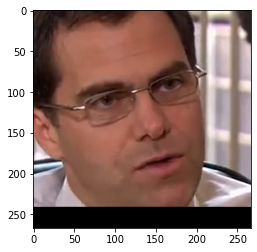

7


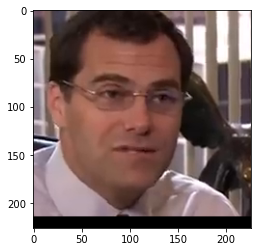

9


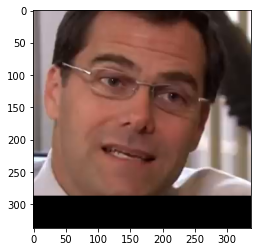

11


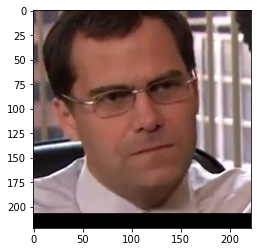

13


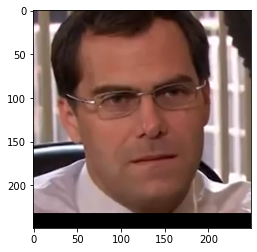

15


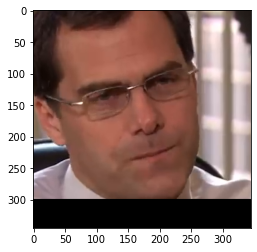

16


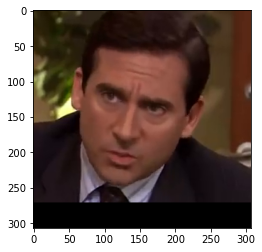

17


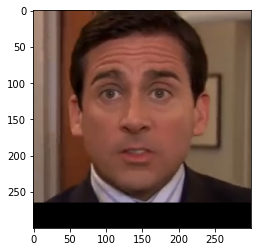

27


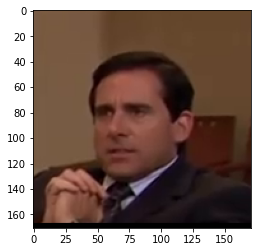

""


In [57]:
selected_df[selected_df['tracker'].isin(groups[3])].groupby('tracker').apply(view_3)

### Clustering Using KMeans

[0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 2 0 2 1 1 2 2 2 2 2 2 2 2 2 2]


(array([10.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0., 12.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

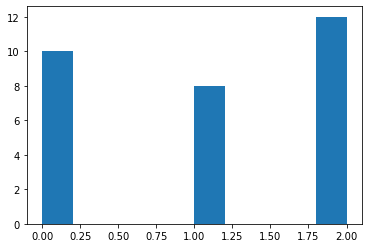

In [58]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(embedding_tracker)
clustering_labels = kmeans.labels_
print(clustering_labels)
plt.hist(clustering_labels)

0


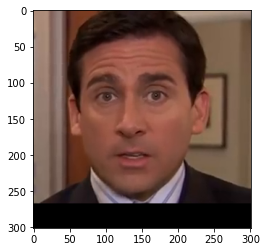

1


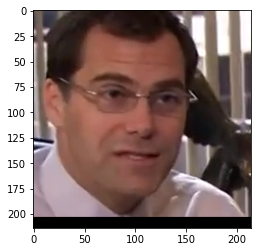

2


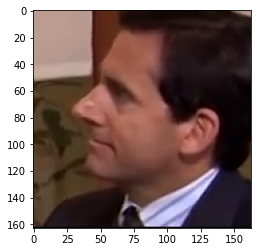

""


In [59]:
cluster_map = dict(zip(embedding_tracker.index,clustering_labels))
selected_df['cluster'] = selected_df['tracker'].apply(lambda x:cluster_map[x] if x in cluster_map.keys() else -1)
selected_df.groupby('cluster').apply(lambda x: view_3(x))

### Using SIFT Descriptors

In [60]:
sift_desc = Sift(sections)

In [61]:
embeddings = np.zeros((len(sift_desc),128))
for i,desc in enumerate(sift_desc):
    if desc is None:
        print(i)
        embeddings[i] = np.zeros(128)
        continue
    embeddings[i] = bow(desc)
    

3214
3512


In [62]:
embedding_df = pd.DataFrame(embeddings)
embedding_df['tracker'] = selected_df['tracker']
embedding_tracker = embedding_df.groupby("tracker").apply(bow).iloc[:,:128]

[0 1 2 3 4 5 6 7]


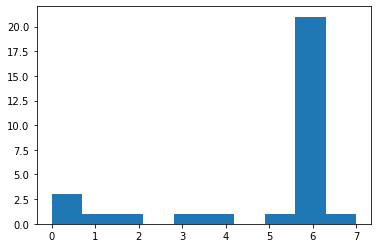

In [67]:
clustering_labels = DBSCAN_clustering(embedding_tracker,2,1)

### Using VGG Model

In [ ]:
#### Extra Work ####

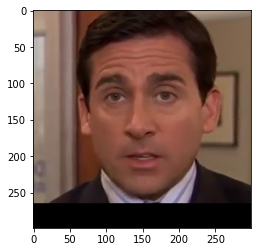

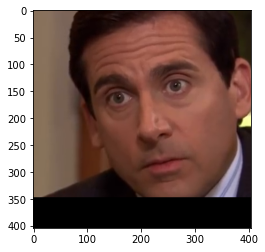

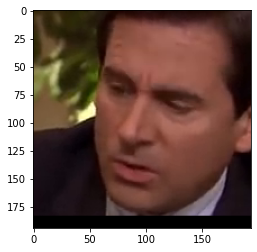

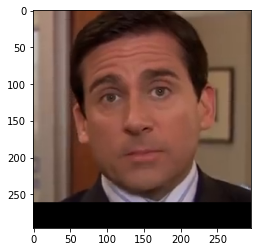

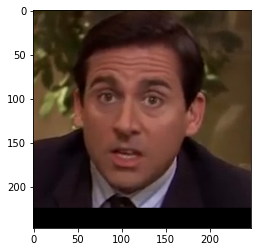

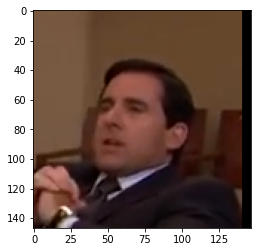

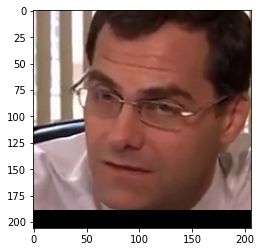

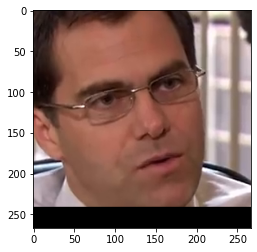

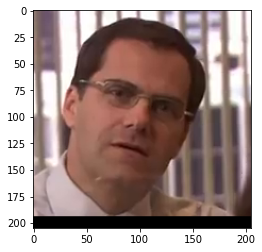

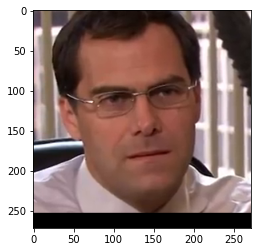

In [68]:
sections = df.apply(lambda x: extract_image(x['frame'],x['left'],x['top'],x['width'],x['height']),axis=1)
sections = sections.apply(lambda x:  cv2.resize(x, dsize=(224, 224), interpolation=cv2.INTER_CUBIC))
sections = sections.apply(lambda x:  x.reshape(1,224,224,3))
sections = np.concatenate(sections.values)
(sections.shape)
for i in range(10):
    df.sample(1).apply(lambda x:view_image(x['frame'],x['left'],x['top'],x['width'],x['height']),axis=1)

In [ ]:
model = Model(inputs=model_vgg16_conv.input,
          outputs=model_vgg16_conv.get_layer('fc2').output)


# preprocess your image to be able to enter the neural network
inputs = preprocess_input(sections[:,:,:,:])
#predict image features
images_features = model.predict(inputs)
vector = images_features[0]
print(vector.shape)

print(vector)

In [392]:
embedding_df = pd.DataFrame(images_features)
embedding_df['tracker'] = selected_df['tracker']
embedding_tracker = embedding_df.groupby("tracker").apply(bow).iloc[:,:4096]

[0 1 2 3 4]
0


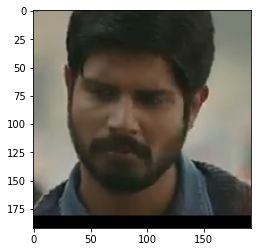

1


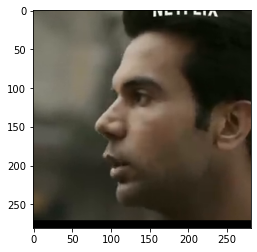

2


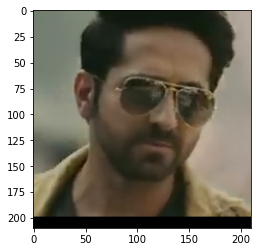

3


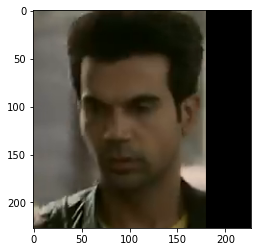

4


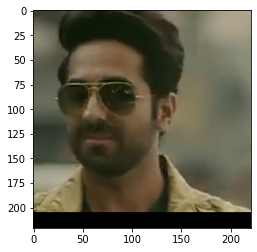

""


In [410]:
clustering_labels = DBSCAN_clustering(embedding_tracker,20,1)
cluster_map = dict(zip(embedding_tracker.index,clustering_labels))
selected_df['cluster'] = selected_df['tracker'].apply(lambda x:cluster_map[x] if x in cluster_map.keys() else -1)
selected_df.groupby('cluster').apply(lambda x: view_3(x))

In [388]:
pca = PCA(n_components = 128 )
pca.fit(images_features.T)

PCA(n_components=128)

In [ ]:
print(pca.components_.shape)

In [ ]:
data = pca.components_

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(pca.components_.T)
kmeans.labels_

In [ ]:
clustering = DBSCAN(eps =1.3, min_samples=2).fit(data/(np.sum(data**2,axis = 1) + 1e-30).reshape(-1,1))
clustering.labels_

In [ ]:
bd = df[["tracker"]]

In [ ]:
bd = pd.DataFrame(embeddings)

In [ ]:
bd['tracker'] = df[["tracker"]]

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(bd)


In [ ]:
plt.hist(kmeans.labels_)

In [ ]:
s = (data - np.mean(data,axis=1).reshape(-1,1)) / (np.std(data,axis = 1).reshape(-1,1) + 1e-100)

In [ ]:
cosine = lambda a,b : np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [ ]:
cosine(s[0],s[1]),cosine(s[0],s[2]),cosine(s[0],s[3]),cosine(s[0],s[4])

In [ ]:
data = bd.groupby("tracker").sum().values

In [ ]:
np.sqrt(np.sum((data[3]-data[0])**2))

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(s)


In [ ]:
plt.hist(kmeans.labels_)

In [ ]:
bd = bd.dropna()

In [ ]:
df = df.iloc[bd.index].copy()

In [ ]:
clustering = DBSCAN(eps = 7.5, min_samples=1).fit(bd)
clustering.labels_

In [ ]:
np.unique(clustering.labels_)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data)

df['tracker_group'] = clustering.labels_